### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 3 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 03 мая, -4 балла после 08:30 10 мая, -6 баллов после 08:30 17 мая, -8 баллов после 08:30 24 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from collections import defaultdict

np.random.seed(42)

In [47]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=3, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()
        self.feature_importances_ = defaultdict(float)
        
        if criterion == 'entropy':
            self.impurity = self.__entropy
        elif criterion == 'gini':
            self.impurity = self.__gini
        elif criterion == 'misclass':
            self.impurity = self.__misclass

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]
    
    def __gini(self, l_c, l_s, r_c, r_s):
        l_s = l_s.astype('float').reshape(-1,1)
        r_s = r_s.astype('float').reshape(-1,1)
        total = (1 - np.sum(((l_c + r_c)/(l_s + r_s)) ** 2, axis=1)).reshape(-1, 1)
        left = (1 - np.sum((l_c / l_s) ** 2, axis=1)).reshape(-1, 1) * l_s / (l_s + r_s)
        right = (1 - np.sum((r_c / r_s) ** 2, axis=1)).reshape(-1, 1) * r_s / (l_s + r_s)
        return total - (left + right)
    
    def __entropy(self, l_c, l_s, r_c, r_s):
        eps = np.random.rand() / 1e4
        l_s = l_s.astype('float') + eps
        r_s = r_s.astype('float') + eps
        total = (-np.sum((l_c + r_c + eps) / (l_s + r_s) * \
                         np.log((l_c + r_c + eps) / (l_s + r_s)), axis=1)).reshape(-1, 1)
        left = (-np.sum((l_c + eps) / l_s * np.log((l_c + eps) / l_s), axis=1))\
                .reshape(-1, 1) * l_s / (l_s + r_s)
        right = (-np.sum(((r_c + eps) / r_s) * np.log((r_c + eps) / r_s), axis=1))\
                .reshape(-1, 1) * r_s / (l_s + r_s)
        return total - (left + right)
    
    def __misclass(self,l_c, l_s, r_c, r_s):
        l_s = l_s.astype('float')
        r_s = r_s.astype('float')
        total = (1 - np.max((l_c + r_c) / (l_s + r_s), axis=1)).reshape(-1, 1)
        left = (1 - np.max(l_c / l_s, axis=1)).reshape(-1, 1) * l_s / (l_s + r_s)
        right = (1 - np.max(r_c / r_s, axis=1)).reshape(-1, 1) * r_s / (l_s + r_s)
        return total - (left + right)
    
    def __find_threshold(self, X, Y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используем разные impurity в зависимости от self.criterion
        """
        thresholds = []
        for feature in range(X.shape[1]):
            x, y = X[:, feature], Y.copy()
            idx_sort = np.argsort(x)
            x = x[idx_sort]
            y = y[idx_sort]
            
            label_change = np.where(y[1:] != y[:-1])[0] + 1
            if label_change.size == 0:
                return -np.inf, 0

            index = np.zeros((label_change.shape[0], self.num_class))
            index[np.arange(label_change.shape[0]), y[label_change - 1]] = 1

            elems = np.append(0, label_change[:-1])
            elem_count = index * (label_change - elems).reshape(-1, 1)
            
            left = np.cumsum(elem_count, axis=0)
            right = np.bincount(y, minlength=self.num_class) - left
            left_size = label_change.reshape(-1, 1)
            right_size = y.shape[0] - left_size
            
            values = self.impurity(left, left_size, right, right_size)
            idx_min = np.argmax(values)
            thresholds.append([values[idx_min], (x[left_size[idx_min][0] - 1] + \
                                                 x[left_size[idx_min][0]]) / 2])
        
        thresholds = np.asarray(thresholds, dtype=object)
        ind = np.argmax(thresholds[:, 0])
        return ind, thresholds[ind]

    def __make_leaf(self, y):
        count = np.bincount(y)
        return count.argmax(), count.max() / y.shape[0]
        
    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """

        if depth == self.max_depth or y.size < self.min_samples_split or np.unique(y).size == 1:
            label, p = self.__make_leaf(y)
            self.tree[node_id] = (self.LEAF_TYPE, label, p)
            return
        
        feature_id, th = self.__find_threshold(x, y)
        self.feature_importances_[feature_id] += th[0]
        
        x_l, x_r, y_l, y_r = self.__div_samples(x, y, feature_id, th[1])
        if y_l.size == 0 or y_r.size == 0:
            label, p = self.__make_leaf(y)
            self.tree[node_id] = (self.LEAF_TYPE, label, p)
            return
        
        self.tree[node_id] = (self.NON_LEAF_TYPE, feature_id, th[1])
        self.__fit_node(x_l, y_l, 2 * node_id + 1, depth + 1)
        self.__fit_node(x_r, y_r, 2 * node_id + 2, depth + 1)

    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        return self.feature_importances_

In [57]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.2, 
                                                    stratify=wine.target, random_state=42)

In [62]:
clf = DecisionTreeClassifier(min_samples_split=2)
my_clf = MyDecisionTreeClassifier(min_samples_split=2)

In [59]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9722222222222222
0.9722222222222222


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [65]:
%time clf.fit(X_train, y_train)

CPU times: user 2.2 ms, sys: 4 µs, total: 2.2 ms
Wall time: 2.16 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [66]:
%time my_clf.fit(X_train, y_train)

CPU times: user 16.6 ms, sys: 0 ns, total: 16.6 ms
Wall time: 17.1 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [67]:
df = pd.read_csv('sdd.csv', encoding='latin1')
df.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,partner,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field,field_cd,undergra,mn_sat,tuition,race,...,amb5_2,you_call,them_cal,date_3,numdat_3,num_in_3,attr1_3,sinc1_3,intel1_3,fun1_3,amb1_3,shar1_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr4_3,sinc4_3,intel4_3,fun4_3,amb4_3,shar4_3,attr2_3,sinc2_3,intel2_3,fun2_3,amb2_3,shar2_3,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,1,11.0,0,0.14,0,27.0,2.0,35.0,20.0,20.0,20.0,0.0,5.0,0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0,2.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,...,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,2,12.0,0,0.54,0,22.0,2.0,60.0,0.0,0.0,40.0,0.0,0.0,0,7.0,8.0,10.0,7.0,7.0,5.0,8.0,4.0,2.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,...,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,3,13.0,1,0.16,1,22.0,4.0,19.0,18.0,19.0,18.0,14.0,12.0,1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,1.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,...,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,4,14.0,1,0.61,0,23.0,2.0,30.0,5.0,15.0,40.0,5.0,5.0,1,7.0,8.0,9.0,8.0,9.0,8.0,7.0,7.0,2.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,...,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,5,15.0,1,0.21,0,24.0,3.0,30.0,10.0,20.0,10.0,10.0,20.0,1,8.0,7.0,9.0,6.0,9.0,7.0,8.0,6.0,2.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,...,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


In [68]:
df = df.iloc[:, :97]
df = df.drop(['id', 'idg', 'condtn', 'round', 'position',
              'positin1', 'order', 'partner', 'age_o', 'race_o',
              'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun',
              'pf_o_amb', 'pf_o_sha', 'dec_o', 'attr_o',
              'sinc_o', 'intel_o',  'amb_o',
              'shar_o',  'prob_o', 'met_o'], axis=1)

df = df.dropna(subset=['age'])
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].dropna()
df = df.drop(['field'], axis=1)

df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)
df.loc[:, 'mn_sat'] = df.mn_sat.dropna()
df = df.drop(['undergra'], axis=1)
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float)
df.loc[:, 'tuition'] = df.tuition.dropna()
df = df.dropna(subset=['imprelig', 'imprace'])
df = df.drop(['from', 'zipcode'], axis=1)
df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float)
df.loc[:, 'income'] = df.loc[:, 'income'].dropna()
df = df.dropna(subset=['date'])
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].dropna()
df = df.drop(['career'], axis=1)
df = df.drop(['sports', 'tvsports', 'exercise', 'dining',
              'museums', 'art', 'hiking', 'gaming',
              'clubbing', 'reading', 'tv', 'theater',
              'movies', 'concerts', 'music', 'shopping', 'yoga'], axis=1)
df = df.drop(['expnum'], axis=1)


feat = ['iid', 'wave', 'attr1_1', 'sinc1_1',
        'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']

temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1',
                                        'intel1_1', 'fun1_1',
                                        'amb1_1', 'shar1_1']].sum(axis=1)

df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1',
           'fun1_1', 'amb1_1', 'shar1_1']] = (
    df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1',
               'fun1_1', 'amb1_1', 'shar1_1']].T /
    df.loc[:, 'temp_totalsum'].T).T * 100


feat = ['iid', 'wave', 'attr2_1', 'sinc2_1',
        'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']

temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1',
                                      'intel2_1', 'fun2_1',
                                      'amb2_1', 'shar2_1']].sum(axis=1)

df.loc[:, ['attr2_1', 'sinc2_1',
           'intel2_1', 'fun2_1',
           'amb2_1', 'shar2_1']] = (
    df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1',
               'fun2_1', 'amb2_1', 'shar2_1']].T /
    df.loc[:, 'temp_totalsum'].T).T * 100

df = df.drop(['temp_totalsum'], axis=1)


for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i),
            'intel{}_1'.format(i), 'fun{}_1'.format(i),
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    df = df.drop(feat, axis=1)

    
df = df.drop(['wave'], axis=1)
df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
    .drop(['gender'], axis=1).dropna()

df_female = df.query('gender == 0').drop_duplicates(subset=['iid'])\
    .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1).dropna()

df_female.columns = df_female.columns + '_f'

In [69]:
df = df_male.merge(df_female, how='inner', left_on='pid', right_on='iid_f')
df

,iid,pid,match,int_corr,samerace,fun_o,like_o,age,field_cd,mn_sat,tuition,race,imprace,imprelig,income,goal,date,go_out,career_c,exphappy,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,iid_f,pid_f,fun_o_f,like_o_f,age_f,field_cd_f,mn_sat_f,tuition_f,race_f,imprace_f,imprelig_f,income_f,goal_f,date_f,go_out_f,career_c_f,exphappy_f,attr1_1_f,sinc1_1_f,intel1_1_f,fun1_1_f,amb1_1_f,shar1_1_f,attr2_1_f,sinc2_1_f,intel2_1_f,fun2_1_f,amb2_1_f,shar2_1_f,attr3_1_f,sinc3_1_f,fun3_1_f,intel3_1_f,amb3_1_f
0,246,234.0,0,0.44,0,5.0,4.0,25.0,10.0,1140.0,9168.0,2.0,7.0,1.0,41476.0,1.0,7.0,6.0,2.0,3.0,35.0,20.0,10.0,20.0,10.0,5.0,40.000000,5.00000,5.000000,30.000000,15.000000,5.000000,7.0,8.0,6.0,7.0,6.0,234,243.0,7.0,7.0,22.0,3.0,1070.0,12696.0,6.0,1.0,5.0,44346.0,3.0,7.0,3.0,2.0,5.0,20.0,20.0,20.0,10.0,10.0,20.0,75.0,1.0,1.0,3.0,10.0,10.0,7.0,7.0,8.0,8.0,10.0
1,248,234.0,0,0.23,1,8.0,6.0,27.0,8.0,1360.0,26062.0,6.0,1.0,1.0,49841.0,1.0,4.0,1.0,7.0,6.0,25.0,15.0,20.0,20.0,15.0,5.0,20.000000,15.00000,15.000000,25.000000,20.000000,5.000000,5.0,6.0,8.0,8.0,8.0,234,243.0,7.0,7.0,22.0,3.0,1070.0,12696.0,6.0,1.0,5.0,44346.0,3.0,7.0,3.0,2.0,5.0,20.0,20.0,20.0,10.0,10.0,20.0,75.0,1.0,1.0,3.0,10.0,10.0,7.0,7.0,8.0,8.0,10.0
2,246,236.0,0,0.26,0,5.0,6.0,25.0,10.0,1140.0,9168.0,2.0,7.0,1.0,41476.0,1.0,7.0,6.0,2.0,3.0,35.0,20.0,10.0,20.0,10.0,5.0,40.000000,5.00000,5.000000,30.000000,15.000000,5.000000,7.0,8.0,6.0,7.0,6.0,236,243.0,5.0,6.0,24.0,10.0,1400.0,26630.0,4.0,3.0,3.0,42225.0,2.0,7.0,1.0,2.0,7.0,15.0,20.0,15.0,20.0,15.0,15.0,30.0,10.0,10.0,30.0,10.0,10.0,7.0,9.0,10.0,8.0,8.0
3,248,236.0,0,-0.03,0,8.0,7.0,27.0,8.0,1360.0,26062.0,6.0,1.0,1.0,49841.0,1.0,4.0,1.0,7.0,6.0,25.0,15.0,20.0,20.0,15.0,5.0,20.000000,15.00000,15.000000,25.000000,20.000000,5.000000,5.0,6.0,8.0,8.0,8.0,236,243.0,5.0,6.0,24.0,10.0,1400.0,26630.0,4.0,3.0,3.0,42225.0,2.0,7.0,1.0,2.0,7.0,15.0,20.0,15.0,20.0,15.0,15.0,30.0,10.0,10.0,30.0,10.0,10.0,7.0,9.0,10.0,8.0,8.0
4,246,237.0,0,0.24,1,2.0,3.0,25.0,10.0,1140.0,9168.0,2.0,7.0,1.0,41476.0,1.0,7.0,6.0,2.0,3.0,35.0,20.0,10.0,20.0,10.0,5.0,40.000000,5.00000,5.000000,30.000000,15.000000,5.000000,7.0,8.0,6.0,7.0,6.0,237,243.0,8.0,7.0,34.0,7.0,1290.0,15309.0,2.0,10.0,1.0,37405.0,3.0,7.0,4.0,6.0,4.0,10.0,20.0,20.0,20.0,20.0,10.0,30.0,5.0,15.0,30.0,10.0,10.0,8.0,10.0,7.0,8.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,535,527.0,0,0.35,0,7.0,6.0,23.0,10.0,1210.0,23500.0,2.0,5.0,6.0,48137.0,1.0,5.0,3.0,2.0,6.0,23.0,14.0,19.0,16.0,10.0,18.0,20.000000,15.00000,15.000000,20.000000,20.000000,10.000000,6.0,7.0,6.0,7.0,5.0,527,531.0,5.0,1.0,24.0,11.0,1290.0,15309.0,6.0,5.0,5.0,32386.0,1.0,4.0,3.0,11.0,1.0,50.0,20.0,10.0,5.0,10.0,5.0,70.0,5.0,5.0,5.0,10.0,5.0,10.0,10.0,10.0,10.0,10.0
304,537,527.0,0,0.62,0,6.0,3.0,22.0,5.0,1309.0,15162.0,4.0,7.0,1.0,61686.0,1.0,5.0,1.0,1.0,7.0,20.0,5.0,25.0,25.0,5.0,20.0,14.285714,9.52381,14.285714,23.809524,14.285714,23.809524,7.0,9.0,9.0,9.0,7.0,527,531.0,5.0,1.0,24.0,11.0,1290.0,15309.0,6.0,5.0,5.0,32386.0,1.0,4.0,3.0,11.0,1.0,50.0,20.0,10.0,5.0,10.0,5.0,70.0,5.0,5.0,5.0,10.0,5.0,10.0,10.0,10.0,10.0,10.0
305,543,527.0,0,0.13,0,5.0,4.0,24.0,5.0,1320.0,25533.0,4.0,9.0,6.0,47624.0,1.0,7.0,2.0,5.0,8.0,20.0,16.0,16.0,17.0,16.0,15.0,20.000000,16.00000,16.000000,17.000000,16.000000,15.000000,7.0,9.0,9.0,8.0,9.0,527,531.0,5.0,1.0,24.0,11.0,1290.0,15309.0,6.0,5.0,5.0,32386.0,1.0,4.0,3.0,11.0,1.0,50.0,20.0,10.0,5.0,10.0,5.0,70.0,5.0,5.0,5.0,10.0,5.0,10.0,10.0,10.0,10.0,10.0
306,544,527.0,0,0.17,0,5.0,5.0,23.0,5.0,1309.0,15162.0,4.0,3.0,8.0,36673.0,1.0,7.0,3.0,4.0,5.0,15.0,25.0,20.0,10.0,10.0,20.0,20.000000,20.00000,10.000000,20.000000,10.000000,20.000000,7.0,10.0,10.0,9.0,8.0,527,531.0,5.0,1.

In [70]:
X = df.drop(['match', 'iid', 'pid', 'iid_f', 'pid_f'], axis=1)
y = df['match']

X_ = X.values
y_ = y.values

X.shape, y.shape

((308, 66), (308,))

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, random_state=42)

In [72]:
clf = DecisionTreeClassifier(min_samples_split=2)
my_clf = MyDecisionTreeClassifier(min_samples_split=2)

clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.8571428571428571
0.922077922077922


Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [75]:
scores = defaultdict(list)
min_splits = range(2, 11)
max_depths = range(1, 11)
criterions = ['gini', 'entropy', 'misclass']
for split in min_splits:
    for depth in max_depths:
        for crit in criterions:
            iter_score = []
            for train, val in KFold(n_splits=3, shuffle=True).split(X_, y_):
                my_clf = MyDecisionTreeClassifier(criterion=crit, 
                                                  max_depth=depth,
                                                  min_samples_split=split)
                my_clf.fit(X_[train], y_[train])
                iter_score.append(accuracy_score(y_[val], my_clf.predict(X_[val])))
            print(f"{np.mean(iter_score)} -- ({crit}, {split}, {depth})")
            scores[np.mean(iter_score)].append((crit, split, depth))

0.8701694269940986 -- (gini, 2, 1)
0.869979059584999 -- (entropy, 2, 1)
0.8637603908877467 -- (misclass, 2, 1)
0.8538612856145695 -- (gini, 2, 2)
0.8602385938194047 -- (entropy, 2, 2)
0.8700742432895489 -- (misclass, 2, 2)
0.8765784631004506 -- (gini, 2, 3)
0.8571292594707787 -- (entropy, 2, 3)
0.8668379973348562 -- (misclass, 2, 3)
0.8504981280538105 -- (gini, 2, 4)
0.8376166000380735 -- (entropy, 2, 4)
0.8505933117583604 -- (misclass, 2, 4)
0.8506567675613934 -- (gini, 2, 5)
0.8538930135160862 -- (entropy, 2, 5)
0.8506250396598768 -- (misclass, 2, 5)
0.8767053747065169 -- (gini, 2, 6)
0.8540199251221524 -- (entropy, 2, 6)
0.8669014531378895 -- (misclass, 2, 6)
0.8376800558411066 -- (gini, 2, 7)
0.8538930135160859 -- (entropy, 2, 7)
0.8667428136303066 -- (misclass, 2, 7)
0.8701694269940986 -- (gini, 2, 8)
0.8312075639317215 -- (entropy, 2, 8)
0.8603972333269878 -- (misclass, 2, 8)
0.8604606891300209 -- (gini, 2, 9)
0.8540199251221524 -- (entropy, 2, 9)
0.873342217145758 -- (misclass, 

In [77]:
np.max(list(scores.keys())), scores[np.max(list(scores.keys()))]

(0.8928231486769466, [('gini', 4, 10)])

In [78]:
depth_score = defaultdict(float)
split_score = defaultdict(float)

for item in scores.items():
    for elem in item[1]:
        depth_score[elem[2]] += item[0]
        split_score[elem[1]] += item[0]

for key in depth_score.keys():
    depth_score[key] /= 9 * 3

for key in split_score.keys():
    split_score[key] /= 10 * 3

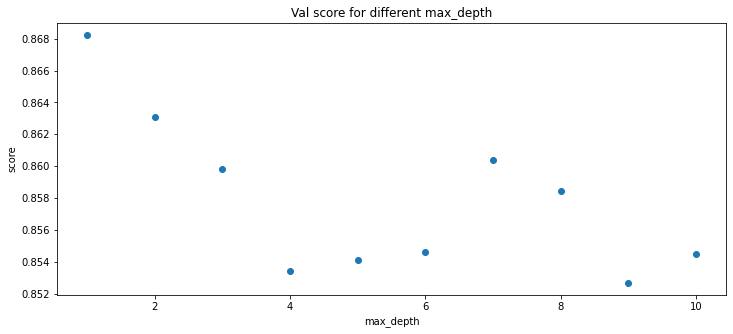

In [79]:
plt.figure(figsize=(12, 5))
plt.scatter(list(depth_score.keys()), list(depth_score.values()))
plt.xlabel('max_depth')
plt.ylabel('score')
plt.title('Val score for different max_depth')
plt.show()
plt.show()

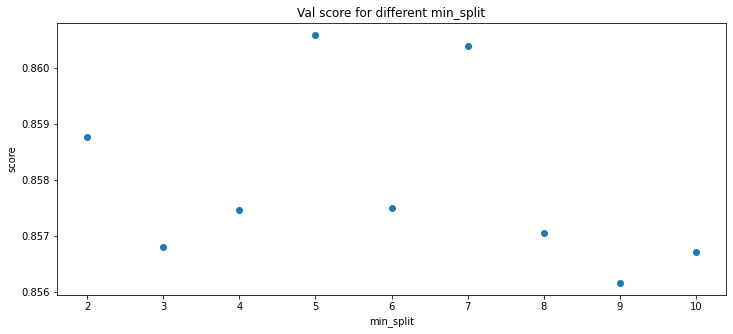

In [80]:
plt.figure(figsize=(12, 5))
plt.scatter(list(split_score.keys()), list(split_score.values()))
plt.xlabel('min_split')
plt.ylabel('score')
plt.title('Val score for different min_split')
plt.show()
plt.show()

Наивысший скор 0.8928 показала модель с параметрами ('gini', min_split=4, max_depth=10)

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [81]:
my_clf = MyDecisionTreeClassifier(criterion='gini', min_samples_split=4, max_depth=10)
my_clf.fit(X_train, y_train)

In [82]:
feature_imp = my_clf.get_feature_importance()
feature_imp = sorted(feature_imp.items(), key=lambda x: x[1], reverse=True)

indices = [x[0] for x in feature_imp]
values = [x[1] for x in feature_imp]
names = X.columns[indices]

print('Feature importances')
for i, val in enumerate(values):
    print(f"{names[i]}: {val[0]}")

Feature importances
like_o: 0.4431093270247809
fun_o: 0.31999999999999984
race: 0.31999999999999984
imprelig: 0.3111111111111111
income: 0.2895660203139429
attr1_1_f: 0.17294117647058826
goal_f: 0.1460336538461538
mn_sat: 0.13265306122448983
attr3_1: 0.10766491243635662
shar2_1_f: 0.018882646691635696
amb1_1_f: 0.017386939289790515


## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

